In [ ]:
# Maurio's Documentaton for Multi-Network Thermal Example

{}
Total number of Errors: 0


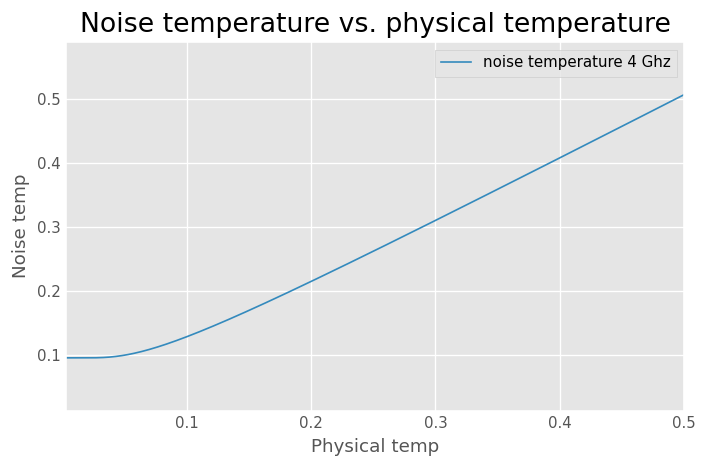

In [15]:
import skrf as rf
import numpy as npy
from skrf.constants import *
%matplotlib inline
from pylab import * 
rf.stylely()

#Test the 

sys2 = rf.NetworkNoiseCov
temps = npy.linspace(.0030,.5,501)
Tn = sys2.Tnoise(4e9,temps)

figure(0)
ylabel('Noise temp')
xlabel('Physical temp')
title('Noise temperature vs. physical temperature')
plot(temps, Tn, label=r'noise temperature 4 Ghz')
# semilogx(frequency.f_scaled, rf.mf.mag_2_db10(fukui_nf), label=r'Fukui NF')
# semilogx(frequency.f_scaled, model_nfmin_db,'--' , label=r'Model min NF')
# semilogx(frequency.f_scaled, model_nf_db,'--', label=r'Model NF')

# ylim(1,2)

from skrf.plotting import func_on_all_figs as foaf

# foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()



In [ ]:
frequency = rf.Frequency(start=1000, stop=4000, npoints=6, unit='MHz')
ntwkAttn1_4000mK = rf.components.Attenuator(1, frequency=frequency, T0 = 4)
ntwkAttn2_1000mK = rf.components.Attenuator(3, frequency=frequency, T0 = 1)
ntwkAttn_700mK = rf.components.Attenuator(10, frequency=frequency, T0 = .7)
ntwkAttn_400mk = rf.components.Attenuator(3, frequency=frequency, T0=.4)
ntwkAttn_100mk = rf.components.Attenuator(10, frequency=frequency, T0=.1)
ntwkCirc1 = rf.components.Circulator(0.5, frequency = frequency, T0 = .090)
ntwkCirc2 = rf.components.Circulator(0.5, frequency = frequency, T0 = .090)

ntwkC = rf.cascade_2port(ntwkAttn1_4000mK, ntwkAttn2_1000mK)

sys = rf.MultiNetworkSystem()

# add all the networks to the system
sys.add(ntwkAttn1_4000mK, r'attn_4K')
sys.add(ntwkAttn2_1000mK, r'attn_1K')
sys.add(ntwkAttn_700mK, r'attn_0p7K')
sys.add(ntwkAttn_400mk, r'attn_0p4K')
sys.add(ntwkAttn_100mk, r'attn_0p1K')
sys.add(ntwkCirc1, r'inj_circ')
sys.add(ntwkCirc1, r'jpa_circ')

# make all the connections between the elements
sys.connect(r'attn_4K', 2, r'attn_1K', 1)
sys.connect(r'attn_1K', 2, r'attn_0p7K', 1)
sys.connect(r'attn_0p7K', 2, r'attn_0p4K', 1)
sys.connect(r'attn_0p4K', 2, r'attn_0p1K', 1)
sys.connect(r'attn_0p1K', 2, r'inj_circ', 1)
sys.connect(r'inj_circ', 3, r'jpa_circ', 1)


# set the external port numbers, for this example the reduced network is a two-port network. The following is used to identify port 1 and port 2 of that resulting network.
sys.external_port(r'attn_4K', 1, external_port_number=1)
sys.external_port(r'inj_circ', 2, external_port_number=2)
sys.external_port(r'jpa_circ', 2, external_port_number=3)
sys.external_port(r'jpa_circ', 3, external_port_number=4)

# the verify function make sure that all the ports have been asigned and that everything is consistant for the reduction algorithm
(en, e) = sys.verify()
print(e)
for error in e:
    print(error)
print("Total number of Errors: " + str(en))

# calculate and return the resulting network
ntwk = sys.reduce()
# print(ntwk)
# print(20*npy.log10(npy.abs(ntwk.s)))
# print(ntwk.cs)

In [16]:
A_temps = npy.identity(npy.shape(ntwk.s)[1])
A_temps[0,0] = 1
A_temps[1,1] = 1
A_temps[2,2] = 1
A_temps[3,3] = 1
A_temps[0,0] = 0
kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))
# print('T1 sas: ', kb_SAS1 [:,0,0])
T1 = ntwk.cs[:,0,0]/kb_SAS1[:,0,0]
print('T1: ', T1)

A_temps = npy.identity(npy.shape(ntwk.s)[1])
A_temps[0,0] = 1
A_temps[1,1] = 1
A_temps[2,2] = 1
A_temps[3,3] = 1
A_temps[1,1] = 0
kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))

T2 = ntwk.cs[:,1,1]/kb_SAS1[:,1,1]
# print('T2 sas: ', A_temps1)
print('T2: ', T2)

A_temps = npy.identity(npy.shape(ntwk.s)[1])
A_temps[0,0] = 1
A_temps[1,1] = 1
A_temps[2,2] = 1
A_temps[3,3] = 1
A_temps[2,2] = 0
kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))

T3 = ntwk.cs[:,2,2]/kb_SAS1[:,2,2]
print('T3: ', T3)

A_temps = npy.identity(npy.shape(ntwk.s)[1])
A_temps[0,0] = 1
A_temps[1,1] = 1
A_temps[2,2] = 1
A_temps[3,3] = 1
A_temps[3,3] = 0
kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))

T4 = ntwk.cs[:,3,3]/kb_SAS1[:,3,3]
print('T4: ', T4)

T1:  [933.64047726+0.j 933.8653995 +0.j 934.19334065+0.j 934.62345748+0.j
 935.15470928+0.j 935.78590436+0.j]
T2:  [79.73493523+0.j 81.29622494+0.j 83.5451608 +0.j 86.44688133+0.j
 89.95872862+0.j 94.0324108 +0.j]
T3:  [0.02385289+0.j 0.02470006+0.j 0.02591657+0.j 0.02747977+0.j
 0.0293623 +0.j 0.03153371+0.j]
T4:  [0.01124066+0.j 0.01163989+0.j 0.01221317+0.j 0.01294983+0.j
 0.01383697+0.j 0.01486024+0.j]
